In [4]:
import sys
sys.path.append("..") # this adds to path parent directory in order to import utils file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from tqdm import tqdm
import numpy as np
from sklearn import metrics
from IPython.display import clear_output, Image, display
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.decomposition import PCA
import hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from sklearn.neighbors import kneighbors_graph
import igraph as ig
import louvain
import time
import pickle
import umap
import os
import traceback
## Import custom utils
import louvain_model
import utils
import gmm_utils
import hyperopt_utils

In [5]:
%load_ext autoreload
import importlib
importlib.reload(gmm_utils)
importlib.reload(hyperopt_utils)
importlib.reload(louvain_model)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
elbowAnalysis
silhouetteAnalyis


<module 'louvain_model' from 'C:\\workspace\\ml\\single-cell-sota\\gmm\\louvain_model.py'>

In [6]:
# Check run louvain method
dataset = 'brainCIDR'
df, truth = utils.loadData(dataset)
y = truth.clusters

params={}
params['dataset'] = 'brainCIDR'
params['minCellsPerGene'] = 0
params['minGeneDispersion'] = 0
params['log'] = True # True, False
params['scaler'] = 'standardScaleCells'# 
params['pca_comp'] = 10 #range (3, 300)
params['doUmap'] = False #range (3, 300)
params['umap_comp'] = 3
params['nb_neighbors'] =10 #3 -15

In [7]:
# for k,v in params.items():
#     print(f'self.{k} = {k}', end='\n')

In [8]:
model = louvain_model.LouvainModel(**params)
# model.fitPredict(df)
# model.evaluate(y)
model.runAll()

C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


{'dataset': 'brainCIDR',
 'nb_neighbors': 10,
 'umap_comp': 3,
 'doUmap': False,
 'pca_comp': 10,
 'scaler': 'standardScaleCells',
 'log': True,
 'minGeneDispersion': 0,
 'minCellsPerGene': 0,
 '_rand_index': 0.5360162720133931,
 '_homogeneity_score': 0.9163660411943687,
 '_purity_score': 0.9571428571428572,
 '_adjusted_mutual_info_score': 0.662014031477782,
 '_fowlkes_mallows_score': 0.6376827817969709,
 '_silhouette_score': -0.033133085505346264,
 '_calinski_harabaz_score': 19.85121380985692,
 '_davies_bouldin_score': 3.2203706989276144}

In [9]:
from sklearn.model_selection import cross_val_score
model = louvain_model.LouvainModel(nb_neighbors=8)
cross_val_score(model, df, y, scoring = model.scorer, cv = 10)

scorer (42, 22085), (42,)
scorer (42, 22085), (42,)
scorer (42, 22085), (42,)
scorer (42, 22085), (42,)
scorer (42, 22085), (42,)
scorer (42, 22085), (42,)
scorer (42, 22085), (42,)
scorer (42, 22085), (42,)
scorer (42, 22085), (42,)
scorer (42, 22085), (42,)


array([-0.00379643,  0.00194291,  0.91796214,  0.29904863,  0.69905138,
        0.37559202,  0.76448731,  0.5216639 ,  0.61918418,  0.21115147])

## Hyperopt utils

In [10]:
method = 'louvain'

In [11]:

def runHyperopt(trialsFile, resultsFile, space, max_evals = 2, restart = False):
    # Define function to optimise
    def evaluateLouvain(args):
        try:
            resultDict=louvain_model.LouvainModel(**args).runAll()
            if os.path.isfile(resultsFile):
                results = pd.read_pickle(resultsFile)

                newDf = pd.DataFrame.from_dict(resultDict, orient='index').T
                results = results.append(newDf)
            else:
                results = pd.DataFrame.from_dict(resultDict, orient='index').T
            results.to_pickle(resultsFile)
        except:
            traceback.print_exc(file=sys.stdout)
            return { 'status' : hyperopt.STATUS_FAIL}

        print(f'>> Result: {resultDict["_rand_index"]}')
        ret = {
            'loss' : -resultDict['_rand_index']
            ,'status' : STATUS_OK
            ,'eval_time' : time.time()        
        }
        return ret

    trials = hyperopt_utils.getTrials(trialsFile ,restart = restart )
    evals_per_epoch = 10
    for e in range(len(trials), max_evals, evals_per_epoch):
        best = fmin(evaluateLouvain
                    ,space
                    ,algo=tpe.suggest 
                    ,max_evals= e + evals_per_epoch
                    ,trials=trials)
        print('Index ', e)
#         pickle.dump(trials, open(trialsFile, 'wb'))
    return trials

## Brain CIDR

In [12]:
dataset = 'brainCIDR'
space = {
    'dataset' : dataset
    ,'minCellsPerGene':scope.int(hp.quniform('minCellsPerGene', 0, 5, 1))
    ,'minGeneDispersion':hp.uniform('minGeneDispersion', 0, 1.5)
    ,'log' : hp.choice('log', [True,False])
    ,'scaler' : hp.choice('scaler',
            ['none','standardScaleGenes', 'standardScaleCells', 'robustScaleGenes', 'robustScaleCells'])
    ,'pca_comp' : scope.int(hp.quniform('pca_comp', 5, 300,1))
    ,'doUmap' : hp.choice('doUmap', [True,False])
    ,'umap_comp' : scope.int(hp.quniform('umap_comp', 2, 5,1))
    ,'nb_neighbors' : scope.int(hp.quniform('nb_neighbors', 6, 30, 1))
}

trialsFile = f'data/{dataset}_{method}_trials.pkl'
resultsFile = f'data/{dataset}_{method}_results.pkl'

In [ ]:
trials = runHyperopt(trialsFile, resultsFile, space, max_evals = 500, restart = True);

(510, 17)


,_adjusted_mutual_info_score,_calinski_harabaz_score,_davies_bouldin_score,_fowlkes_mallows_score,_homogeneity_score,_purity_score,_rand_index,_silhouette_score,dataset,doUmap,log,minCellsPerGene,minGeneDispersion,nb_neighbors,pca_comp,scaler,umap_comp
0,0.815274,37.9363,2.63718,0.921795,0.819955,0.880952,0.900713,0.0771985,brainCIDR,False,False,3,0.420347,26,290,standardScaleCells,2
0,0.815274,37.9363,2.63718,0.921795,0.819955,0.880952,0.900713,0.0771985,brainCIDR,False,False,5,0.342787,10,289,standardScaleCells,2
0,0.833131,32.2482,2.64746,0.921588,0.838257,0.907143,0.900562,0.0790847,brainCIDR,False,False,4,0.561687,21,293,standardScaleCells,2


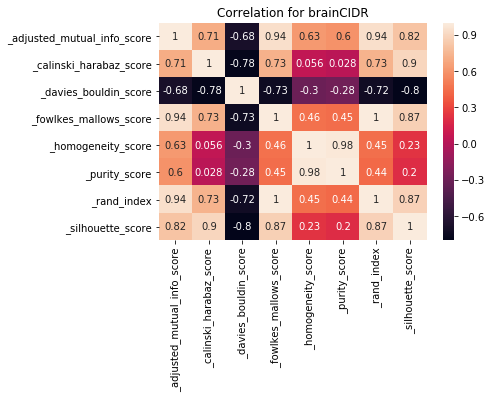

In [13]:
resultsDf = pd.read_pickle(resultsFile)
print(resultsDf.shape)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
gmm_utils.plotCorrelation(resultsDf, name=dataset)

## PancreaticIsletCIDR

In [ ]:
dataset= 'pancreaticIsletCIDR'
df, truth = gmm_utils.loadData(dataset)
print(df.shape, truth.shape, truth.clusters.unique())
trialsFile = f'data/{dataset}_{method}_trials.pkl'
resultsFile = f'data/{dataset}_{method}_results.pkl'

In [ ]:

space = {
    'dataset' : dataset
    ,'minCellsPerGene':scope.int(hp.quniform('minCellsPerGene', 0, 5, 1))
    ,'minGeneDispersion':hp.uniform('minGeneDispersion', 0, 1.5)
    ,'log' : hp.choice('log', [True,False])
    ,'scaler' : hp.choice('scaler',
            ['none','standardScaleGenes', 'standardScaleCells', 'robustScaleGenes', 'robustScaleCells'])
    ,'pca_comp' : scope.int(hp.quniform('pca_comp', 5, 300,1))
    ,'doUmap' : hp.choice('doUmap', [True,False])
    ,'umap_comp' : scope.int(hp.quniform('umap_comp', 2, 5,1))
    ,'nb_neighbors' : scope.int(hp.quniform('nb_neighbors', 6, 30, 1))
}



In [ ]:
trials=hyperopt_utils.getTrials(filename ,restart = False )

In [ ]:
trials = runHyperopt(trialsFile, resultsFile, space, max_evals = 500, restart = True);

In [ ]:

resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
gmm_utils.plotCorrelation(resultsDf, name=dataset)

## Deng

In [ ]:
dataset= 'deng'
df, truth = gmm_utils.loadData(dataset)
print(df.shape, truth.shape, truth.clusters.unique())
trialsFile = f'data/{dataset}_{method}_trials.pkl'
resultsFile = f'data/{dataset}_{method}_results.pkl'

In [ ]:
space = {
    'dataset' : dataset
    ,'minCellsPerGene':scope.int(hp.quniform('minCellsPerGene', 0, 5, 1))
    ,'minGeneDispersion':hp.uniform('minGeneDispersion', 0, 1.5)
    ,'log' : hp.choice('log', [True,False])
    ,'scaler' : hp.choice('scaler',
            ['none','standardScaleGenes', 'standardScaleCells', 'robustScaleGenes', 'robustScaleCells'])
    ,'pca_comp' : scope.int(hp.quniform('pca_comp', 5, 200,1))
    ,'doUmap' : hp.choice('doUmap', [True,False])
    ,'umap_comp' : scope.int(hp.quniform('umap_comp', 2, 5,1))
    ,'nb_neighbors' : scope.int(hp.quniform('nb_neighbors', 6, 30, 1))
}
trials = runHyperopt(trialsFile, resultsFile, space, max_evals = 500, restart = True);

In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
utils.plotCorrelation(resultsDf, name=dataset)

# sce10x_qc

In [ ]:
dataset= 'sce10x_qc'
df, truth = utils.loadData(dataset)
print(df.shape, truth.shape, truth.clusters.unique())
trialsFile = f'data/{dataset}_{method}_trials.pkl'
resultsFile = f'data/{dataset}_{method}_results.pkl'

In [ ]:
space = {
    'dataset' : dataset
    ,'minCellsPerGene':scope.int(hp.quniform('minCellsPerGene', 0, 5, 1))
    ,'minGeneDispersion':hp.uniform('minGeneDispersion', 0, 1.5)
    ,'log' : hp.choice('log', [True,False])
    ,'scaler' : hp.choice('scaler',
            ['none','standardScaleGenes', 'standardScaleCells', 'robustScaleGenes', 'robustScaleCells'])
    ,'pca_comp' : scope.int(hp.quniform('pca_comp', 5, 200,1))
    ,'doUmap' : hp.choice('doUmap', [True,False])
    ,'umap_comp' : scope.int(hp.quniform('umap_comp', 2, 5,1))
    ,'nb_neighbors' : scope.int(hp.quniform('nb_neighbors', 6, 30, 1))
}
trials = runHyperopt(trialsFile, resultsFile, space, max_evals = 500, restart = True);

In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
utils.plotCorrelation(resultsDf, name=dataset)

# sce2_qc

In [ ]:
dataset= 'sce2_qc'
df, truth = utils.loadData(dataset)
print(df.shape, truth.shape, truth.clusters.unique())
trialsFile = f'data/{dataset}_{method}_trials.pkl'
resultsFile = f'data/{dataset}_{method}_results.pkl'

In [ ]:
space = {
    'dataset' : dataset
    ,'minCellsPerGene':scope.int(hp.quniform('minCellsPerGene', 0, 5, 1))
    ,'minGeneDispersion':hp.uniform('minGeneDispersion', 0, 1.5)
    ,'log' : hp.choice('log', [True,False])
    ,'scaler' : hp.choice('scaler',
            ['none','standardScaleGenes', 'standardScaleCells', 'robustScaleGenes', 'robustScaleCells'])
    ,'pca_comp' : scope.int(hp.quniform('pca_comp', 5, 200,1))
    ,'doUmap' : hp.choice('doUmap', [True,False])
    ,'umap_comp' : scope.int(hp.quniform('umap_comp', 2, 5,1))
    ,'nb_neighbors' : scope.int(hp.quniform('nb_neighbors', 6, 30, 1))
}
trials = runHyperopt(trialsFile, resultsFile, space, max_evals = 500, restart = True);

In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
utils.plotCorrelation(resultsDf, name=dataset)

# sce8_qc

In [ ]:
dataset= 'sce8_qc'
df, truth = utils.loadData(dataset)
print(df.shape, truth.shape, truth.clusters.unique())
trialsFile = f'data/{dataset}_{method}_trials.pkl'
resultsFile = f'data/{dataset}_{method}_results.pkl'

In [ ]:
space = {
    'dataset' : dataset
    ,'minCellsPerGene':scope.int(hp.quniform('minCellsPerGene', 0, 5, 1))
    ,'minGeneDispersion':hp.uniform('minGeneDispersion', 0, 1.5)
    ,'log' : hp.choice('log', [True,False])
    ,'scaler' : hp.choice('scaler',
            ['none','standardScaleGenes', 'standardScaleCells', 'robustScaleGenes', 'robustScaleCells'])
    ,'pca_comp' : scope.int(hp.quniform('pca_comp', 5, 200,1))
    ,'doUmap' : hp.choice('doUmap', [True,False])
    ,'umap_comp' : scope.int(hp.quniform('umap_comp', 2, 5,1))
    ,'nb_neighbors' : scope.int(hp.quniform('nb_neighbors', 6, 30, 1))
}
trials = runHyperopt(trialsFile, resultsFile, space, max_evals = 500, restart = True);

In [ ]:
resultsDf = pd.read_pickle(resultsFile)
display(resultsDf.sort_values(by='_rand_index', ascending = False).head(3))
utils.plotCorrelation(resultsDf, name=dataset)

In [ ]:
bestBic, bestAic, bestSil = optimalNbClustersGMM(pc, params['min_clusters'], params['max_clusters'], 2)

In [ ]:
bestBic, bestAic, bestSil

In [ ]:
for n_clust in n_clusters:
    model = GaussianMixture(n_clust, covariance_type ='full', random_state = 0).fit(pc)
    clusters = model.predict(pc)
    score = adjusted_rand_score(truth.clusters.tolist(), clusters)
    print(f"For {n_clust} clusters, score : {score}")

## Evaluation

In [ ]:
model = GaussianMixture(8, covariance_type ='full', random_state = 0).fit(pc)
clusters = model.predict(pc)
score = adjusted_rand_score(truth.clusters.tolist(), clusters)
score

In [ ]:
truth.clusters.value_counts().shape

In [ ]:
dataset = 'brainCIDR'
df, truth = gmm_utils.loadData(dataset)
umap2D = gmm_utils.getUmap(df, pca_comp = 10)
print(df.shape, truth.shape, truth.clusters.unique())
params={}
params['dataset'] = 'brainCIDR'
params['minCellsPerGene'] = 0
params['minGeneDispersion'] = 0
params['log'] = True # True, False
params['scaler'] = 'standardScaleCells'# 
params['pca_comp'] = 10 #range (3, 300)
params['nb_clusters'] =8 #3 -15
gmm_utils.run(params);